<a href="https://colab.research.google.com/github/tylerb55/COMP530/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/tylerb55/COMP530.git

Cloning into 'COMP530'...
remote: Enumerating objects: 4204, done.
remote: Counting objects: 100% (1177/1177), done.
remote: Compressing objects: 100% (1173/1173), done.
remote: Total 4204 (delta 4), reused 1177 (delta 4), pack-reused 3027
Receiving objects: 100% (4204/4204), 913.69 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import PIL.Image as Image

In [2]:
mobileNetv2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

classifier_model = mobileNetv2

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

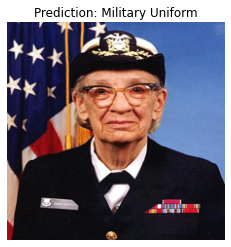

In [3]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape
predicted_class = tf.math.argmax(result[0], axis=-1)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Split the test and validation set

In [4]:
def Train_Validation_Test_Set(directory_name):
  """a function to load the images in a large directory into a tensorflow dataset object
  the data is split 80:10:10 in training:validation:test. The dataset is shuffled before splitting
  and the images are formatted to 512x512 pixels and grayscale(one color channel and the values range from 0 to 255)"""
  dataset_train=tf.keras.preprocessing.image_dataset_from_directory('/content/COMP530/'+directory_name,
                                                                    labels='inferred',
                                                                    label_mode='int',
                                                                    class_names=['NormalCases','cancercases'],
                                                                    image_size=(512,512),
                                                                    shuffle=True,
                                                                    seed=305,
                                                                    validation_split=0.2,
                                                                    subset='training',
                                                                    batch_size=None
                                                                    )

  dataset_validation=tf.keras.preprocessing.image_dataset_from_directory('/content/COMP530/'+directory_name,
                                                                    labels='inferred',
                                                                    label_mode='int',
                                                                    class_names=['NormalCases','cancercases'],
                                                                    image_size=(512,512),
                                                                    shuffle=True,
                                                                    seed=305,
                                                                    validation_split=0.2,
                                                                    subset='validation',
                                                                    batch_size=None
                                                                    )
  
  dataset_test=tf.keras.preprocessing.image_dataset_from_directory('/content/COMP530/'+directory_name,
                                                                    labels='inferred',
                                                                    label_mode='int',
                                                                    class_names=['NormalCases','cancercases'],
                                                                    image_size=(512,512),
                                                                    shuffle=True,
                                                                    seed=305,
                                                                    validation_split=0.1,
                                                                    subset='validation',
                                                                    batch_size=None
                                                                    )
    
  dataset_validation=dataset_validation.take(dataset_test.__len__())

  return dataset_train,dataset_validation,dataset_test

In [5]:
def ResNetPreprocess(image,label):
  image = image/255.0
  # Resize images from 512x512 to 224x224
  image = tf.image.resize(image, (224,224))
  return image, label

In [6]:
BATCH_SIZE=32

dataset_train,dataset_validation, dataset_test=Train_Validation_Test_Set("Dataset1")
dataset_train=dataset_train.map(ResNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)
dataset_validation=dataset_validation.map(ResNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)
dataset_test=dataset_test.map(ResNetPreprocess).batch(batch_size=BATCH_SIZE,drop_remainder=True)

AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_validation = dataset_validation.cache().prefetch(buffer_size=AUTOTUNE)

Found 1097 files belonging to 2 classes.
Using 878 files for training.
Found 1097 files belonging to 2 classes.
Using 219 files for validation.
Found 1097 files belonging to 2 classes.
Using 109 files for validation.


(32, 224, 224, 3)
(32,)


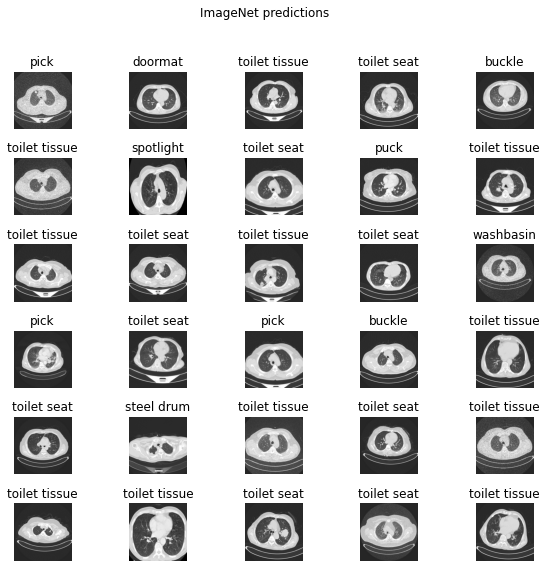

In [7]:
for image_batch, labels_batch in dataset_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

result_batch = classifier.predict(dataset_train)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [8]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch = feature_extractor_layer(image_batch)

num_classes = 1

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

predictions = model(image_batch)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['acc'])

NUM_EPOCHS = 30

history = model.fit(dataset_train,
                    validation_data=dataset_validation,
                    epochs=NUM_EPOCHS)

Epoch 1/30
27/27 [==============================] - 6s 103ms/step - loss: 2.5608 - acc: 0.6771 - val_loss: 1.9535 - val_acc: 0.7708
Epoch 2/30
27/27 [==============================] - 1s 39ms/step - loss: 4.4218 - acc: 0.6748 - val_loss: 6.0362 - val_acc: 0.6042
Epoch 3/30
27/27 [==============================] - 1s 38ms/step - loss: 5.1137 - acc: 0.6366 - val_loss: 3.6437 - val_acc: 0.6979
Epoch 4/30
27/27 [==============================] - 1s 38ms/step - loss: 1.9624 - acc: 0.7917 - val_loss: 2.0501 - val_acc: 0.7604
Epoch 5/30
27/27 [==============================] - 1s 39ms/step - loss: 1.7827 - acc: 0.8009 - val_loss: 1.8396 - val_acc: 0.7708
Epoch 6/30
27/27 [==============================] - 1s 39ms/step - loss: 1.6760 - acc: 0.8160 - val_loss: 2.2452 - val_acc: 0.7812
Epoch 7/30
27/27 [==============================] - 1s 39ms/step - loss: 1.6069 - acc: 0.8090 - val_loss: 2.0973 - val_acc: 0.7812
Epoch 8/30
27/27 [==============================] - 1s 39ms/step - loss: 1.5611 - 

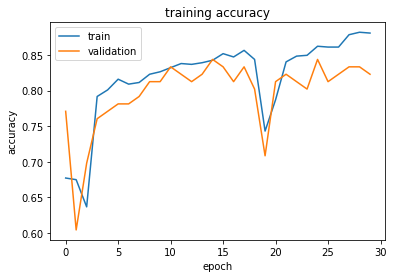

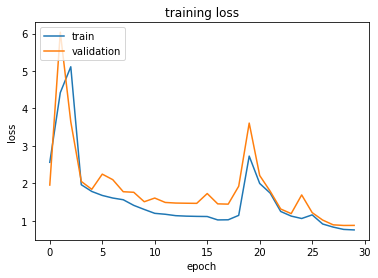

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def ResNet_model():
   return tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),activation='relu',input_shape=(227,227,1)),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
                                      tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation='relu',padding='same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
                                      tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(4096,activation='relu'),
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.Dense(4096,activation='relu'),
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.Dense(1,activation='softmax')
])

ResNet = ResNet_model()

In [ ]:
ResNet.compile(loss='binary_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001),metrics=['accuracy'])
ResNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
history=ResNet.fit(dataset_train,epochs=50,validation_data=dataset_validation,validation_freq=1)

Epoch 1/50
27/27 [==============================] - 12s 110ms/step - loss: 1.2768 - accuracy: 0.6215 - val_loss: 0.6832 - val_accuracy: 0.6042
Epoch 2/50
27/27 [==============================] - 3s 47ms/step - loss: 0.6965 - accuracy: 0.6215 - val_loss: 0.6736 - val_accuracy: 0.5938
Epoch 3/50
27/27 [==============================] - 3s 47ms/step - loss: 0.6171 - accuracy: 0.6192 - val_loss: 0.6262 - val_accuracy: 0.6875
Epoch 4/50
27/27 [==============================] - 3s 54ms/step - loss: 0.4544 - accuracy: 0.6192 - val_loss: 0.6940 - val_accuracy: 0.5625
Epoch 5/50
27/27 [==============================] - 3s 46ms/step - loss: 0.3835 - accuracy: 0.6204 - val_loss: 0.6454 - val_accuracy: 0.6458
Epoch 6/50
27/27 [==============================] - 3s 55ms/step - loss: 0.2635 - accuracy: 0.6215 - val_loss: 0.6759 - val_accuracy: 0.6354
Epoch 7/50
27/27 [==============================] - 3s 54ms/step - loss: 0.2259 - accuracy: 0.6227 - val_loss: 0.7023 - val_accuracy: 0.6146
Epoch 8/50


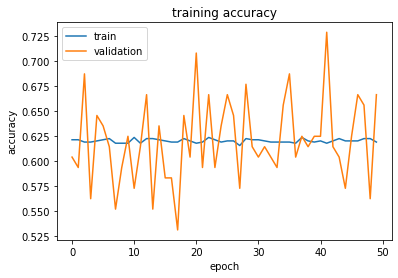

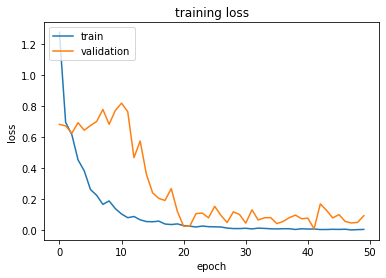

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Test the model on the test set and evaluate performance

In [ ]:
ResNet.evaluate(dataset_test)

3/3 [==============================] - 0s 24ms/step - loss: 0.0977 - accuracy: 0.5521


[0.09770000725984573, 0.5520833134651184]

Produce graphs and visualisations for test data

In [ ]:
predictions=ResNet.predict(dataset_test)
target=np.array([],'int32')
for element in dataset_test.as_numpy_iterator():
  target=np.append(target,element[1])

epoch_precision=[]
epoch_recall=[]
epoch_accuracy=[]
tp=0
tn=0
fp=0
fn=0
for i in range(len(predictions)):
  if(np.argmax(predictions[i])==1 and target[i]==1):
    tp+=1
  elif(np.argmax(predictions[i])==1 and target[i]==0):
    fp+=1
  elif(np.argmax(predictions[i])==0 and target[i]==0):
    tn+=1
  elif(np.argmax(predictions[i])==0 and target[i]==1):
    fn+=1
  if((i+1)%BATCH_SIZE==0):
    epoch_accuracy.append((tp+tn)/(tp+fn+tn+fp))
    epoch_precision.append((tp/(fp+tp)))
    epoch_recall.append((tp/(fn+tp)))
print("accuracy:",epoch_accuracy)
print("recall:",epoch_recall)
print("precision:",epoch_precision)


ZeroDivisionError: ignored